In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os

### Start up PBS cluster
 - may need to adjust project and/or walltime

In [2]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [3]:
client.cluster

### Some custom functions

In [4]:
def month_wts(nyears):
    '''
    returns an xr.DataArray of days per month, tiled for nyears
    '''
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [31]:
def get_files(htape,yr0=1850,yr1=2014):
    keys=[]
    files=[]
    for i in range(501):
        k='LHC'+str(i).zfill(4)
        d='/glade/scratch/djk2120/PPEn11_transient_'+k+'/run/'
        f=sorted(glob.glob(d+'*.h0.*'))
        if len(f)==33:
            files.append(f)
            keys.append(k)
    return files,keys

In [129]:
def get_files(htape,yr0=1850,yr1=2014):
    d='/glade/campaign/asp/djk2120/PPEn11/transient/hist/'

    #find all files
    fs   = np.array(sorted(glob.glob(d+'*'+htape+'*')))
    yrs  = np.array([int(f.split(htape)[1][1:5]) for f in fs])
    keys = np.array([f.split('.clm2')[0][-7:] for f in fs])

    #bump back yr0, if needed
    uyrs=np.unique(yrs)
    dy=uyrs[1]-yrs[0]
    yr0=dy*int(yr0/dy)
    
    #find index to subset files
    ix   = (yrs>=yr0)&(yrs<=yr1)
    yrs  = yrs[ix]
    keys = keys[ix]

    #subset and reshape files
    ny=np.sum(keys=='LHC0000')
    nens = int(len(keys)/ny)
    files = fs[ix].reshape([nens,ny])

    #convert to list of lists
    files = [list(f) for f in files]
    
    return files,np.unique(keys)

In [118]:
def add_params(ds,df):
    mems=df['member'].values
    ix1=0*mems==1
    for key in keys:
        ix1=(ix1)|(mems==key)

    nens=len(ds.ens)    
    ix2=0*np.arange(nens)==1
    for mem in mems:
        ix2=(ix2)|(ds.key==mem)


    params=[]    
    for p in df.keys():
        if p!='member':
            x=xr.DataArray(np.nan+np.zeros(nens),dims='ens')
            x[ix2]=df[p][ix1]
            ds[p]=x
            params.append(p)
    ds['params']=xr.DataArray(params,dims='param')

In [175]:
def get_ds(dvs,htape,yr0=1850,yr1=2014,dropdef=False):
    
    def preprocess(ds):
        return ds[dvs]
    
    #read in the data
    files,keys = get_files(htape,yr0,yr1)
    if dropdef:
        files = files[1:]
        keys  = keys[1:]
    
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                       parallel=True,preprocess=preprocess)
    
    #fix the time dimension, if needed
    yr0=str(ds['time.year'].values[0])
    if (htape=='h0')|(htape=='h1'):
        ds['time']=xr.cftime_range(yr0,periods=len(ds.time),freq='MS')
    
    #add some param info, etc.
    df=pd.read_csv('/glade/scratch/djk2120/PPEn11/lhc220701.txt')
    ds['key']=xr.DataArray(keys,dims=['ens'])
    add_params(ds,df)
    
    #add landarea info
    la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
    la = xr.open_dataset(la_file).landarea  #km2
    ds['la'] = la
    
    return ds
    

In [168]:
def gmean(da,la,cf=1):
    #global mean
    xg=cf/la.sum()*(la*da).sum(dim='gridcell').compute()
    return xg


In [169]:
def amean(da,cf=1):
    #annual mean
    ny = len(np.unique(da['time.year']))
    m  = month_wts(ny)
    
    xa = cf/365/ny*(m*da).sum(dim='time').compute()
    return xa

### Start here
 - load and examine the ensemble

In [182]:
%%time
dvs=['TLAI','GPP','SOILWATER_10CM','EFLX_LH_TOT']
htape='h0'
yr0=2005
ds = get_ds(dvs,htape,yr0)

CPU times: user 6.59 s, sys: 199 ms, total: 6.79 s
Wall time: 24.7 s


In [184]:
%%time
# compute avg 2005-2014 GPP
v = 'GPP'
y = amean(gmean(ds[v],ds.la))

CPU times: user 3.95 s, sys: 120 ms, total: 4.07 s
Wall time: 7.09 s


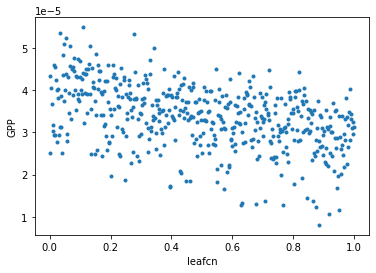

In [185]:
#avg 2005-2014 GPP vs. leafcn
p = 'leafcn'
x = ds[p]

plt.plot(x,y,'.')
plt.xlabel(p)
plt.ylabel(v);

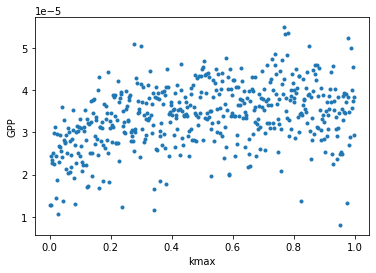

In [186]:
#avg 2005-2014 GPP vs. leafcn
p = 'kmax'
x = ds[p]

plt.plot(x,y,'.')
plt.xlabel(p)
plt.ylabel(v);